In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data/ethusd_group_project.csv")
data['time'] = pd.to_datetime(data['time'])
data.head()

,time,open,close,high,low,volume,"RV_d,t",daily_return,"RV_w,t","RV_m,t","ln_RV_d,t","ln_RV_w,t","ln_RV_m,t"
0,2016-03-09,11.197,11.197,11.197,10.660,41.139523,0.014515,NaN,NaN,NaN,-4.232581,NaN,NaN
1,2016-03-10,11.072,11.750,11.850,11.072,1.030000,0.003658,0.049388,NaN,NaN,-5.610725,NaN,NaN
2,2016-03-11,11.850,11.950,11.950,11.800,50.846991,0.000178,0.017021,NaN,NaN,-8.632636,NaN,NaN
3,2016-03-12,11.950,12.918,13.450,11.950,237.777041,0.007418,0.081004,NaN,NaN,-4.903878,NaN,NaN
4,2016-03-13,13.450,14.456,15.074,13.450,379.267469,0.007416,0.119059,NaN,NaN,-4.904091,NaN,NaN


# feature engineering

In [9]:
features = ['ln_RV_d,t']  # Using only daily RV for LSTM
target = 'ln_RV_d,t'  # Predicting next day's realized variance

# 2️⃣ Create Input Sequences for LSTM
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])  # Past days as input
        y.append(data[i+lookback])    # Next day's target
    return np.array(X), np.array(y)

# Standardize the data (LSTMs perform better with scaled inputs)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# Create sequences
lookback = 60  # Use 30-day rolling window of input features.
X, y = create_sequences(data_scaled, lookback)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow import keras

# Train-Test Split
train_size = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Further split training into training & validation (80% train, 20% validation)
val_size = int(len(X_train) * 0.2)  # 20% of training data
X_val, y_val = X_train[-val_size:], y_train[-val_size:]  # Last 20% for validation
X_train, y_train = X_train[:-val_size], y_train[:-val_size]  # Remaining for training

print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Define LSTM Model
model = Sequential([
    Input(shape=(lookback, len(features))),
    LSTM(256, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(128, return_sequences=False, activation='tanh'), 
    Dropout(0.1),
    Dense(1, activation=None)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

# Train the LSTM Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) #early stopping functionality
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20, batch_size=16, verbose=1,
                    callbacks=[callback])

# Save the model
model.save('../../results/models/lstm_model.keras')

Training Set: (1690, 60, 1) (1690, 1)
Validation Set: (422, 60, 1) (422, 1)
Test Set: (528, 60, 1) (528, 1)
Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.4671 - mean_absolute_percentage_error: 262.1037 - root_mean_squared_error: 0.6826 - val_loss: 0.2180 - val_mean_absolute_percentage_error: 196.8046 - val_root_mean_squared_error: 0.4669
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.3430 - mean_absolute_percentage_error: 220.3035 - root_mean_squared_error: 0.5853 - val_loss: 0.2061 - val_mean_absolute_percentage_error: 196.2699 - val_root_mean_squared_error: 0.4540
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.3242 - mean_absolute_percentage_error: 274.9222 - root_mean_squared_error: 0.5692 - val_loss: 0.2061 - val_mean_absolute_percentage_error: 233.8653 - val_root_mean_squared_error: 0.4540
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.3194 - mean_absolute_percentage_error: 352.0410 - root_mean_squared_error: 0.5646 

In [11]:
# load model
#model = keras.models.load_model('../../results/models/lstm_model.keras')

# Rolling Forecast for Test Set
predictions = []
history = list(X_train[-1])  # Start with last training window

for i in range(len(X_test)):
    pred = model.predict(np.array(history).reshape(1, lookback, len(features)), verbose=0)[0,0]
    predictions.append(pred)

    # Update rolling window (remove first, add latest prediction)
    history.append(y_test[i])  # Use real value (like a true rolling forecast)
    history.pop(0)

# Convert predictions back from log-scale
predictions = np.exp(scaler.inverse_transform(np.array(predictions).reshape(-1,1)))

# Save Predictions
results = pd.DataFrame({'time': data['time'].iloc[train_size+lookback:], 'RV_forecast': predictions.flatten()})
results.to_csv("../../results/models/lstm_forecast.csv", index=False)

🔹 Mean Squared Error (MSE): 0.000003
🔹 Root Mean Squared Error (RMSE): 0.001701
🔹 Mean Absolute Percentage Error (MAPE): 111.712415%
🔹 R² Score: 0.473294


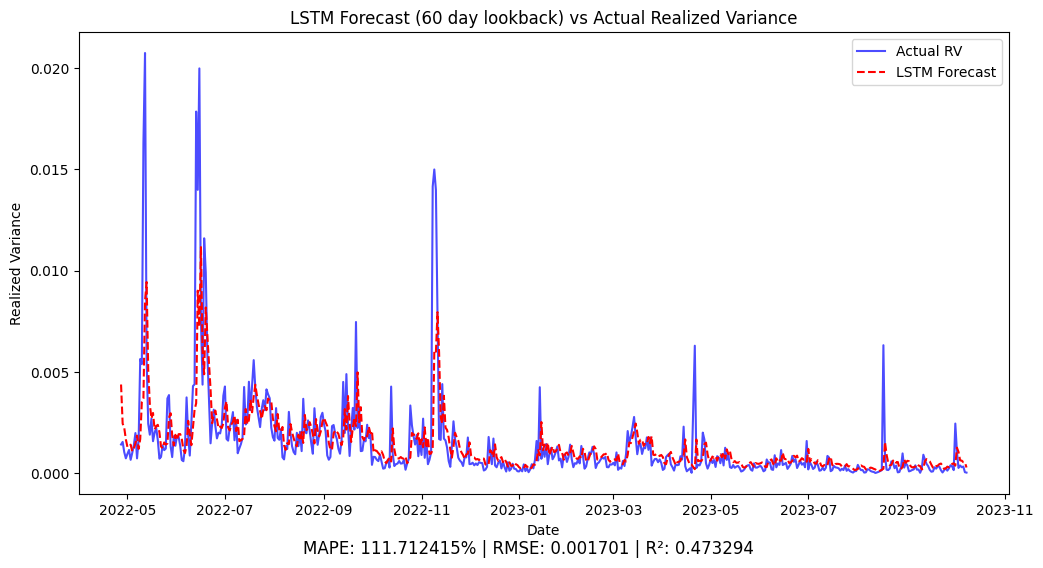

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Load test set
test_actual = np.exp(scaler.inverse_transform(y_test))

# Load LSTM Forecasts
forecast_df = pd.read_csv("../../results/models/lstm_forecast.csv")
lstm_predictions = forecast_df["RV_forecast"].values

# 1️⃣ Calculate Error Metrics
mse = mean_squared_error(test_actual, lstm_predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_actual, lstm_predictions)
r2 = r2_score(test_actual, lstm_predictions)

# Print evaluation metrics
print(f"🔹 Mean Squared Error (MSE): {mse:.6f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"🔹 Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"🔹 R² Score: {r2:.6f}")

# 2️⃣ Plot Actual vs Predicted Realized Variance
plt.figure(figsize=(12,6))
plt.plot(data['time'].iloc[train_size+lookback:], test_actual, label="Actual RV", color="blue", alpha=0.7)
plt.plot(data['time'].iloc[train_size+lookback:], lstm_predictions, label="LSTM Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title(f"LSTM Forecast ({lookback} day lookback) vs Actual Realized Variance")
plt.legend()
#add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/lstm_forecast_plot_{lookback}_lookback1.png')
plt.show()
